In [2]:
%load_ext autoreload
%autoreload 2
from evolution_algos import cem_uncorrelated, saes_1_1, ObjectiveFunction
from evolution_policy import NeuralNetworkPolicy, LogisticRegression

import numpy as np
from src.test_utils import RenderWrapper
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.persistence import RailEnvPersister
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
# from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

from flatland.utils.rendertools import RenderTool

from src.observation_utils import normalize_observation

import time

In [27]:
# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [28]:
# Initializing policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)
print(policy.num_params)

1155


In [29]:
theta = np.random.rand(policy.num_params)

obs, info = env.reset()
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
actions = {}
for agent in env.get_agent_handles():
    actions[agent] = policy.act(agent_obs[agent], theta)

obs, all_rewards, done, _ = env.step(actions)

print(all_rewards)
    

{0: 0, 1: 0}


In [9]:
# Cross entropy method

# Create the objective function
objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

init_mean_array = np.random.random(size = policy.num_params)
init_var_array = np.ones(shape=policy.num_params) * 100.
hist_dict = {}
cem = cem_uncorrelated(
    objective_function,
    mean_array = init_mean_array,
    var_array = init_var_array,
    max_iterations=50,
    sample_size=50,
    elite_frac=0.2,
    print_every=5,
    success_score=10,
    hist_dict=hist_dict
)

iteration :  0
[-0.0, 22.0, 24.0, 50.0, 78.0, 89.0, 93.0, 96.0, 99.0, 112.0, 122.0, 122.0, 122.0, 124.0, 126.0, 126.0, 128.0, 129.0, 131.0, 138.0, 140.0, 140.0, 144.0, 145.0, 145.0, 146.0, 147.0, 151.0, 152.0, 154.0, 158.0, 160.0, 161.0, 164.0, 167.0, 174.0, 179.0, 195.0, 206.0, 212.0, 231.0, 245.0, 247.0, 259.0, 262.0, 269.0, 280.0, 314.0, 316.0, 336.0]
158.6
iteration :  5
[2.0, 24.0, 24.0, 24.0, 32.0, 46.0, 46.0, 51.0, 65.0, 69.0, 78.0, 84.0, 86.0, 86.0, 87.0, 87.0, 87.0, 93.0, 93.0, 96.0, 98.0, 98.0, 109.0, 127.0, 132.0, 133.0, 134.0, 136.0, 136.0, 145.0, 145.0, 157.0, 166.0, 169.0, 171.0, 172.0, 172.0, 178.0, 181.0, 182.0, 193.0, 200.0, 208.0, 209.0, 212.0, 213.0, 216.0, 245.0, 275.0, 304.0]
129.52
iteration :  10
[-0.0, -0.0, -0.0, 7.0, 32.0, 37.0, 38.0, 40.0, 47.0, 47.0, 63.0, 63.0, 72.0, 72.0, 73.0, 80.0, 85.0, 87.0, 96.0, 96.0, 96.0, 103.0, 108.0, 120.0, 123.0, 131.0, 132.0, 133.0, 135.0, 138.0, 139.0, 146.0, 158.0, 165.0, 167.0, 171.0, 171.0, 172.0, 172.0, 172.0, 179.0, 180.0

In [12]:
## I increase the size of the sample and reduce the elite fraction to see if the algorithm converges to a better solution
# Cross entropy method

# Create the objective function
objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

init_mean_array = np.random.random(size = policy.num_params)
init_var_array = np.ones(shape=policy.num_params) * 100.
hist_dict = {}
theta = cem_uncorrelated(
    objective_function,
    mean_array = init_mean_array,
    var_array = init_var_array,
    max_iterations=50,
    sample_size = 50,
    elite_frac=0.1,
    print_every=5,
    success_score=10,
    hist_dict=hist_dict
)

iteration :  0
[78.0, 80.0, 100.0, 102.0, 106.0, 112.0, 114.0, 114.0, 115.0, 126.0, 126.0, 127.0, 129.0, 131.0, 135.0, 136.0, 139.0, 139.0, 141.0, 141.0, 144.0, 150.0, 150.0, 150.0, 152.0, 158.0, 160.0, 164.0, 167.0, 170.0, 172.0, 172.0, 174.0, 174.0, 176.0, 184.0, 185.0, 189.0, 191.0, 198.0, 219.0, 228.0, 240.0, 240.0, 242.0, 249.0, 249.0, 250.0, 254.0, 289.0]
164.62
iteration :  5
[58.0, 78.0, 82.0, 85.0, 96.0, 97.0, 98.0, 98.0, 99.0, 115.0, 118.0, 118.0, 120.0, 120.0, 122.0, 127.0, 131.0, 136.0, 140.0, 144.0, 146.0, 150.0, 151.0, 154.0, 156.0, 158.0, 158.0, 163.0, 168.0, 170.0, 171.0, 173.0, 175.0, 189.0, 190.0, 192.0, 196.0, 202.0, 206.0, 216.0, 226.0, 236.0, 240.0, 253.0, 254.0, 267.0, 277.0, 283.0, 317.0, 339.0]
167.16


: 

In [5]:
hist_dict = {}

init_x_array = np.random.random(size = policy.num_params)
init_sigma_array = np.ones(shape=policy.num_params) * 100.



objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=2 , max_time_steps=200)

saes = saes_1_1(
    objective_function,
    x_array = init_x_array,
    sigma_array = init_sigma_array,
    tau = 0.001,
    max_iterations=100,
    print_every=20,
    success_score=2,
    hist_dict=hist_dict
)
# fonctionne pas

185.5
206.5
197.5
111.0
217.5


In [6]:
saes

array([190.33375314, 190.68133633, 191.06693956, 190.80756985,
       191.18520666, 190.26972423, 191.02983619, 190.72558056,
       190.90024534, 190.66276819, 191.16792731, 190.41626455,
       190.99629567, 190.59299004, 190.64557841, 190.38203   ,
       190.97200149, 190.26754572, 190.80874985, 190.6207044 ,
       190.69363154, 190.45142581, 190.71215622, 190.3801599 ,
       190.39662143, 190.53583828, 190.63002011, 190.69443982,
       190.65563278, 190.45810012, 191.1327351 , 190.30212169,
       190.98731476, 190.69617498, 190.28788239, 191.0232823 ,
       190.69021476, 190.6181391 , 190.29788784, 190.60634319,
       190.7064484 , 191.06517829, 191.23039566, 191.19785585,
       190.36372497, 190.92881212, 190.58781164, 190.6593845 ,
       190.98741183, 191.17884637, 190.76764305, 190.62035647,
       190.54082329, 190.85816821, 190.28695992, 190.41582755,
       190.69174242, 190.66811626, 190.43000513, 191.22392654,
       190.87792146, 190.70253611, 190.36904598, 190.77

In [23]:
for i in range(5):
    print(objective_function(saes))

## ça change c'est bizarre

28.0
37.0
9.0
28.0
2.0


In [3]:
# Create the environment
observation_tree_depth = 1
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=30,
    height=20,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=3,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=4, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [4]:
# Initializing policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)

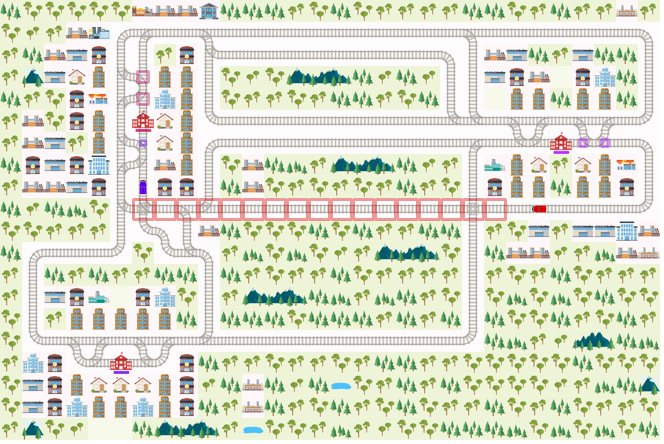

Stopped at time step  110
{0: -95, 1: -33, 2: 0, 3: -85}


In [12]:


state, info = env.reset()
env_renderer = RenderWrapper(env,real_time_render=True, force_gif=False)

max_time_steps = 500

for t in range(max_time_steps):
    env_renderer.render()
    time.sleep(0.2)
    
    agent_obs = [None] * env.get_num_agents()
    for agent in env.get_agent_handles():
        if state[agent]:
            agent_obs[agent] = normalize_observation(state[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
    actions = {}
    for agent in env.get_agent_handles():
        actions[agent] = policy.act(agent_obs[agent], cem)
    
    state, all_rewards, done, info = env.step(actions)
    #print("step : ", t)
    #print("rewards : ", all_rewards)
    #print("actions : ", actions)
    #total_rewards += sum(all_rewards.values())

    if done['__all__']:
        print("Stopped at time step ", t)
        print(all_rewards)
        break